In [4]:
import os
from enum import Enum
import numpy as np
import scipy
import math
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(44, 4)
(15, 4)


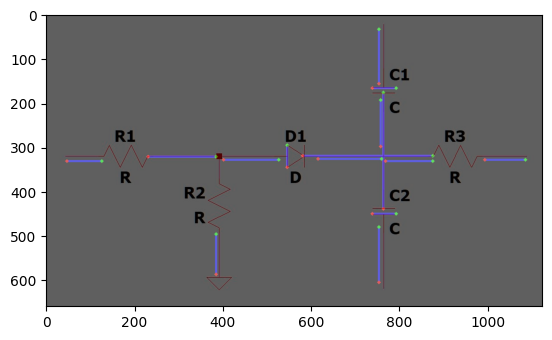

In [2]:


path = os.path.join(os.getcwd(), "output/randomSubFolder")
filelist = [ f for f in os.listdir(path) if f.endswith(".png") ]
for f in filelist:
    os.remove(os.path.join(path, f))

imgOG = cv2.imread('tests/images/schematic.JPG')
alpha = 1 # Contrast control (1.0-3.0)
beta = 0 # Brightness control (0-100)
imageSliceSize = 140 # The size of the subimages of POI analysis
HLThreshold = 10 # Hough Lines Transform threshold
HLMinLineLength = 50 # Hough Lines Transform minLineLength
HLmaxLineGap = 1 # Hough Lines Transform maxLineGap

img = cv2.convertScaleAbs(imgOG, alpha=alpha, beta=beta)

imgLine = np.zeros(img.shape)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(img, 200, 200, None, 5)
lines = cv2.HoughLinesP(edges, rho = 1, theta = math.pi/2, threshold = HLThreshold, minLineLength = HLMinLineLength , maxLineGap = HLmaxLineGap).squeeze()

def saveImageFromPos(img, x, y, winSize, name):
    yMax, xMax, colorChannels = img.shape
    if(x+int(winSize/2) > xMax or y+int(winSize/2) > yMax or x-int(winSize/2) < 0 or y-int(winSize/2) < 0):
        return
    img = img[y-int(winSize/2):y+int(winSize/2), x-int(winSize/2):x+int(winSize/2)]
    filename = 'output/randomSubFolder/' + str(name) +'.png'
    cv2.imwrite(filename, img)

print(lines.shape)
pointDistance = 50

def similairLineInList(list, line):
    for count, l in enumerate(list):
        pt1 = (l[0],l[1])
        pt2 = (l[2],l[3])
        pt3 = (line[0],line[1])
        pt4 = (line[2],line[3])
        if((math.dist(pt1,pt3) < pointDistance and math.dist(pt2,pt4) < pointDistance) or ((math.dist(pt1,pt4) < pointDistance and math.dist(pt2,pt3) < pointDistance))):
            return True
    return False

prunedLinesList = []
prunedLinesList.append(lines[0].tolist())

for count, line in enumerate(lines):
    if(not similairLineInList(prunedLinesList,line)):
        prunedLinesList.append(line.tolist())

prunedLines = np.asarray(prunedLinesList)

for count, line in enumerate(prunedLines):
    pt1 = (line[0],line[1])
    pt2 = (line[2],line[3])
    cv2.line(imgLine, pt1, pt2, (0,0,255), 4)
    cv2.circle(imgLine, pt1, 2, (255,0,0), 3)
    cv2.circle(imgLine, pt2, 2, (0,255,0), 3)
    saveImageFromPos(imgOG.copy(), pt1[0],pt1[1], imageSliceSize, str(count) + 'A')
    saveImageFromPos(imgOG.copy(), pt2[0],pt2[1], imageSliceSize, str(count) + 'B')

print(prunedLines.shape)

fig, ax = plt.subplots()
im2 = ax.imshow(imgLine, vmin=0, vmax=1)
im1 = ax.imshow(img, vmin=0, vmax=1, alpha=0.5)

plt.show()

2023-11-05 12:56:22.884515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-05 12:56:22.952908: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /media/j/USBSSD/TUB/Repos/png2spice/.env/lib/python3.8/site-packages/cv2/../../lib64:
2023-11-05 12:56:22.962636: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /media/j/USBSSD/TUB/Repos/png2spice/.env/lib/python3.8/site-packages/cv2/../../lib64:
2023-11-05 12:56:22.962701: W tensorflow/core/common_runtime/gpu/gpu_device.cc:19

Found 26 images belonging to 1 classes.


2023-11-05 12:56:23.790975: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 333971456 exceeds 10% of free system memory.
2023-11-05 12:56:23.929646: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 333971456 exceeds 10% of free system memory.


1/1 [==============================] - 4s 4s/step
Found 26 images belonging to 1 classes.


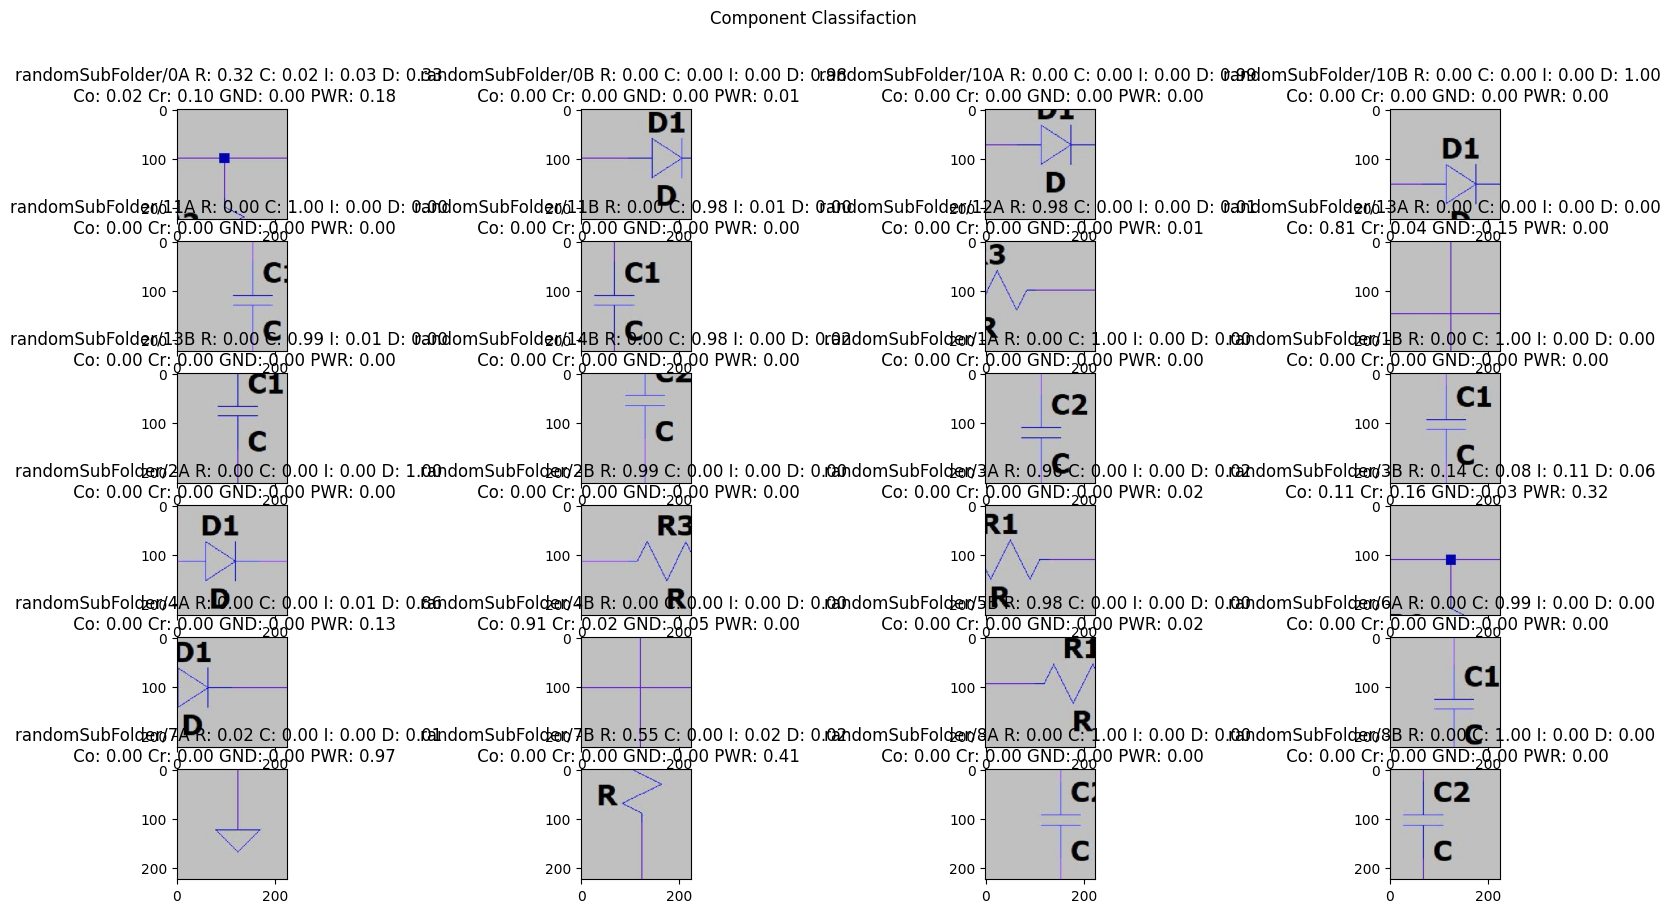

In [3]:
vgg16_model = load_model('SPICEnet/SPICEnet.h5')

image_resize = 224 #WTF IS THIS???

vgg16_prediction = vgg16_model.predict(
    ImageDataGenerator(
        preprocessing_function=preprocess_input,
        ).flow_from_directory(
            'output',
            target_size=(image_resize, image_resize),
            shuffle=False)
)

result_index = ['Capacitor' if (s == 0) else 'Inductor' if (s == 1) else 'Resistance' for s in np.argmax(vgg16_prediction,axis=1)]

my_data_generator = ImageDataGenerator(
    rescale=1./255
)

imageDisplayGenerator = my_data_generator.flow_from_directory(
    'output',
    target_size=(image_resize, image_resize),
    shuffle=False,
    batch_size=100) #THIS IS NE MAX N OF IMAGES TO DISPLAY

fileLabels =  [s.replace('randomSubFolder\\', '').replace('.png', '') for s in imageDisplayGenerator.filenames]

batch_images = imageDisplayGenerator.next()[0]

fig, axs = plt.subplots(nrows=int(imageDisplayGenerator.n/4), ncols=4, figsize=(20, 10)) # define your figure and axes
ind = 0
for ax1 in axs:
    for ax2 in ax1:
        ax2.imshow(batch_images[ind])
        ax2.title.set_text(str(fileLabels[ind]) + " R: %.2f C: %.2f I: %.2f D: %.2f \n Co: %.2f Cr: %.2f GND: %.2f PWR: %.2f" % (vgg16_prediction[ind][0],vgg16_prediction[ind][1],vgg16_prediction[ind][2],vgg16_prediction[ind][3],vgg16_prediction[ind][4],vgg16_prediction[ind][5],vgg16_prediction[ind][6],vgg16_prediction[ind][7]))
        ind += 1

fig.suptitle('Component Classifaction') 
plt.show()

In [5]:

class POITypes(Enum):
    Nothing = 0
    Resistor = 1
    Capacitor = 2
    Inductor = 3
    Diode = 4
    Corner = 5
    Junction = 6
    Cross = 7
    GND = 8
    PWR = 9

class POI:
  def __init__(self):
    self.type = POITypes.Nothing
    self.rotation = None
    self.terminalA = None
    self.terminalB = None
    self.terminalC = None
    self.terminalD = None
    self.value = None
    self.text = None

  def getType(self):
    print("My type is " + str(self.type))

def isValidPOI(POI):
   return POI[0] > 0.99 or POI[1] > 0.99 or POI[2] > 0.99

def pred2Type(POI):
   s = np.argmax(POI)
   return POITypes.Capacitor if (s == 0) else POITypes.Inductor if (s == 1) else POITypes.Resistor

def isValidPOIInList(list, val):
   try:
      return isValidPOI(list[fileLabels.index(val)])
   except ValueError:
      return False

anchorPOIA = POI()
anchorPOIB = POI()

for count, line in enumerate(lines):
   if(isValidPOIInList(vgg16_prediction, str(count) + "A") and isValidPOIInList(vgg16_prediction, str(count) + "B") and anchorPOIA.type == POITypes.Nothing):
      pt1 = (line[0],line[1]) #A
      pt2 = (line[2],line[3]) #B
      anchorPOIA.type = pred2Type(vgg16_prediction[fileLabels.index(str(count) + "A")])
      anchorPOIB.type = pred2Type(vgg16_prediction[fileLabels.index(str(count) + "B")])
      anchorPOIA.terminalA = anchorPOIB
      anchorPOIA.value = str(count) + "A"
      anchorPOIB.terminalB = anchorPOIA
      anchorPOIB.value = str(count) + "B"
      print("ANCHOR: " + str(count) + "A " + str(count) + "B")

anchorPOIA.getType()
anchorPOIB.getType()

#line[x] has the files xA.png and xB.png associated with the two end terminals

#We need to star building up a graph!

#Step 1: Find and anchor | iterate over line till we find one with two valid components at the ends

#Step 2: Find closest differnt line beginning for anchorAComponent Terminal B
#Identify component at the other end of line, and iterate/branch
# Do the same for anchorBComponent Terminal B

#if a line has no two valid components at the end, remove it from dataSet

#We should have a full tree now

My type is POITypes.Nothing
My type is POITypes.Nothing
